# CNN Prototype


In [0]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 2.x selected.


'/device:GPU:0'

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.utils import model_to_dot



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import importlib
import json

import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru



logging.basicConfig(level=logging.INFO)

%matplotlib inline
sns.set()



DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"

DEBUG = False

MODEL_NAME = "CNN"
ARCHITECTURE = "1_kernel3"
if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-200k-preprocessed.csv"

directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"CNN - 1 Layer, 32 filters, kernel size 3"


# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3
PATIENCE = 4

# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 100
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100

In [0]:
df = pd.read_csv(f"{DATA_FILE}")

In [0]:
df.head()

,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date
0,3,0,0,love polka dot,best quality,2015-08-31
1,5,0,0,five star,very good quality price,2015-08-31
2,5,0,0,case work great fit great very sli,wish bottom top edge little rigid case work gr...,2015-08-31
3,5,0,0,perfect,finished using trip loved able keep tablet ope...,2015-08-31
4,1,0,0,cheaply made,low quality earbuds do not stay ear cheaply made,2015-08-31


In [0]:
rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

**Preprocessing**

In [0]:
# one hot encode ratings
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
y

(199134,)
<class 'pandas.core.series.Series'>


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [0]:
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)

Using TensorFlow backend.


In [0]:
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

In [0]:
print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=45009
Number of Documents=149350


**Sequence Normalization**

Figure out max length of review and pad the rest so they are all the same length

In [0]:
df["review_length"] = df.review_body.apply(lambda x: len(x.split()))
df.review_length.max()

4686

In [0]:
df.describe()

,star_rating,helpful_votes,total_votes,review_length
count,199134.000000,199134.000000,199134.000000,199134.000000
mean,3.898023,0.878705,1.141252,25.895794
std,1.459839,11.110737,11.783852,43.820072
min,1.000000,0.000000,0.000000,1.000000
25%,3.000000,0.000000,0.000000,8.000000
50%,5.000000,0.000000,0.000000,15.000000
75%,5.000000,0.000000,1.000000,28.000000
max,5.000000,3378.000000,3468.000000,4686.000000


In [0]:
# pad dataset to a maximum review length in words so that all sequencesa re the same length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,  168,  175,  237, 1411,
         27,  362,   17,  269, 2540,  121,   64,  816,   64,   82,   56,
       1629,  121,   64,   25,    1,   27,    2, 1721, 3158, 1044,  135,
         11], dtype=int32)

In [0]:
rating.head()

0    3
1    5
2    5
3    5
4    1
Name: star_rating, dtype: int64

In [0]:
model = Sequential()
model.add(Embedding(len(t.word_counts)+1, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=FILTER1, kernel_size=KERNEL_SIZE, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])


In [0]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          13503000  
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 250)               400250    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1255      
Total params: 13,933,337
Trainable params: 13,933,337
Non-trainable params: 0
____________________________________________

In [0]:
# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=PATIENCE, 
                              min_lr=0.00001,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)

mw = ku.ModelWrapper(model, MODEL_NAME, LABEL_COLUMN, DATA_FILE, 
                     embedding=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop, reduce_lr])

Number of training examples: 149350
Train on 119480 samples, validate on 29870 samples
Epoch 1/50
119480/119480 [==============================] - 211s 2ms/sample - loss: 0.8865 - categorical_accuracy: 0.6572 - val_loss: 0.8138 - val_categorical_accuracy: 0.6844
Epoch 2/50
119480/119480 [==============================] - 204s 2ms/sample - loss: 0.7208 - categorical_accuracy: 0.7153 - val_loss: 0.8214 - val_categorical_accuracy: 0.6811
Epoch 3/50
119480/119480 [==============================] - 206s 2ms/sample - loss: 0.5907 - categorical_accuracy: 0.7701 - val_loss: 0.8976 - val_categorical_accuracy: 0.6735
Epoch 4/50
119480/119480 [==============================] - 206s 2ms/sample - loss: 0.4502 - categorical_accuracy: 0.8301 - val_loss: 1.0792 - val_categorical_accuracy: 0.6536
Epoch 5/50
119480/119480 [==============================] - 207s 2ms/sample - loss: 0.3414 - categorical_accuracy: 0.8738 - val_loss: 1.3174 - val_categorical_accuracy: 0.6279
Epoch 00005: early stopping


In [0]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

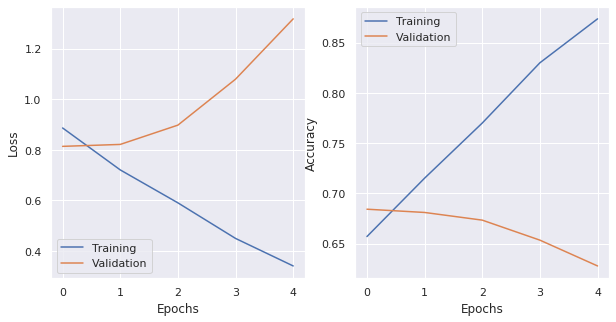


Confusion Matrix
[[ 5662   177   426   101   615]
 [ 1668   173   623   261   500]
 [  909   162  1141  1010  1318]
 [  259    42   573  2202  5222]
 [  350    16   280  1228 24866]]

Classification Report
              precision    recall  f1-score   support

           1       0.64      0.81      0.72      6981
           2       0.30      0.05      0.09      3225
           3       0.37      0.25      0.30      4540
           4       0.46      0.27      0.34      8298
           5       0.76      0.93      0.84     26740

    accuracy                           0.68     49784
   macro avg       0.51      0.46      0.46     49784
weighted avg       0.63      0.68      0.64     49784



drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

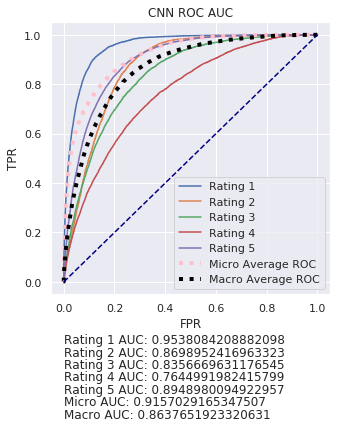

INFO:util.report_util:calculating metric from dictionary


Overall Score: 0.17283226581355474


In [0]:




pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.name, mw.roc_auc, mw.fpr, mw.tpr)
plt.show()

print(f'Overall Score: {ru.calculate_metric(mw.crd)}')

**Save off various files**

In [0]:
mw.save(DRIVE_DIR, append_report=True)

description: amazon_reviews_us_Wireless_v1_00-200k-preprocessed-CNN-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-200k-preprocessed-CNN-100-star_rating-model.h5
Saving json config file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-200k-preprocessed-CNN-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-200k-preprocessed-CNN-100-star_rating-weights.h5


INFO:root:Saving tokenizer file: drive/My Drive/Springboard/capstone/models/dl-tokenizer.pkl


Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
INFO:util.report_util:calculating metric from dictionary
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (b

In [0]:
print(datetime.now())

2019-11-06 03:10:54.455756
